# Imports and Loading the Data

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
file_path = '../data/AMAZON_FASHION.json'

df = pd.read_json(file_path, lines = True) # lines = True tells pandas to treat each line as a single json document

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


# Dataset Exploration - Phase 1

#####  a. Counts and averages.

In [4]:
# This will get an overview of the dataset's scope, including how many unique products are covered using asin (Amazon Standard Identification Number) as well as the reviewer communities size
total_reviews = len(df)                     
unique_products = df['asin'].nunique()
unique_reviewers = df['reviewerID'].nunique()

In [5]:
# averages will help us get an early indication of positive or negative feedback on products 
# as well as let us know if the dataset is dominated by a very few popular products or if it is more evenly distributed
average_rating = df['overall'].mean()
average_review_length = df['reviewText'].str.len().mean()
average_reviews_per_product = total_reviews / unique_products
average_reviews_per_reviewer = total_reviews / unique_reviewers

In [6]:
# Print the results
print(f"Total number of reviews: {total_reviews}")
print(f"Total number of unique products: {unique_products}")
print(f"Total number of unique reviewers: {unique_reviewers}")
print(f"Average rating: {average_rating:.2f}")
print(f"Average review length: {average_review_length:.2f} characters")
print(f"Average number of reviews per product: {average_reviews_per_product:.2f}")
print(f"Average number of reviews per reviewer: {average_reviews_per_reviewer:.2f}")

Total number of reviews: 883636
Total number of unique products: 186189
Total number of unique reviewers: 749233
Average rating: 3.91
Average review length: 147.79 characters
Average number of reviews per product: 4.75
Average number of reviews per reviewer: 1.18


##### b. Distribution of the number of reviews across products
##### c. Distribution of the number of reviews per product
Someone please correct me if im wrong, but b & c are the same ask, just worded differently

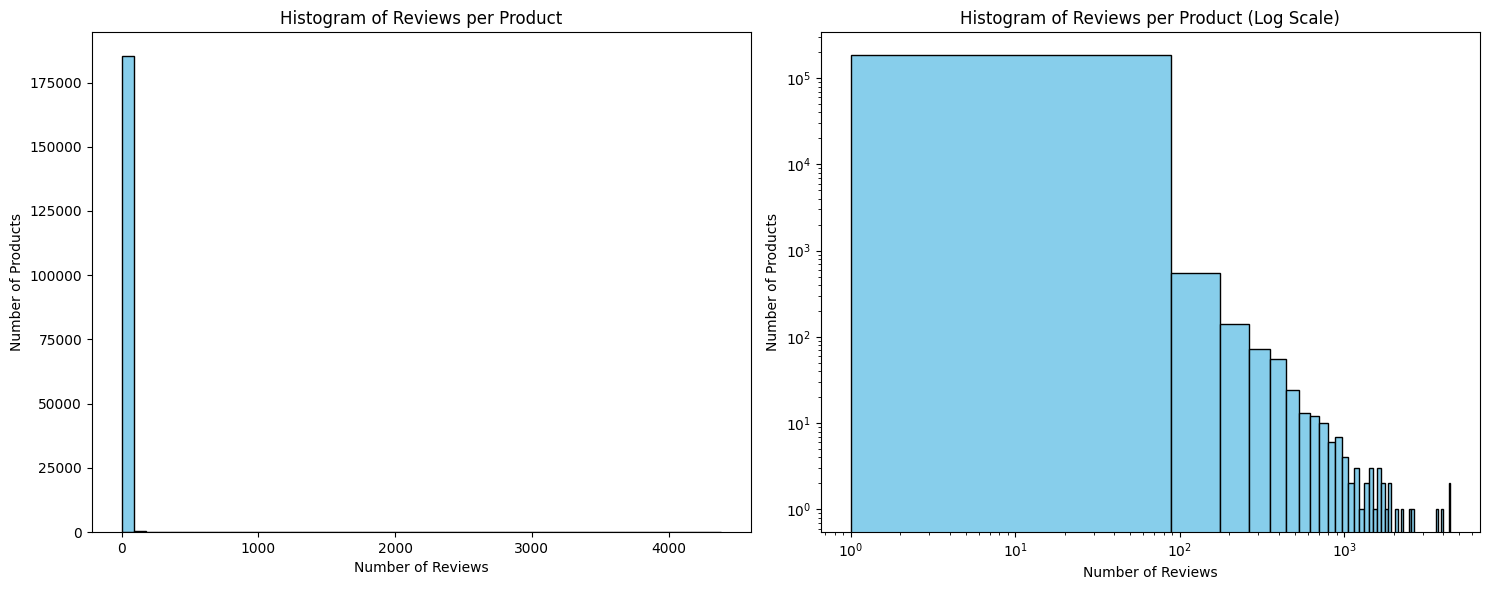

In [12]:
# claculate reviews per product
reviews_per_product = df.groupby('asin')['reviewerID'].count()

# set up the matplotlib figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# regular scale hist
ax1.hist(reviews_per_product, bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Histogram of Reviews per Product')
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Number of Products')

# log scale - This will be more meaningful due to the skewness of the data
ax2.hist(reviews_per_product, bins=50, color='skyblue', edgecolor='black', log=True)
ax2.set_title('Histogram of Reviews per Product (Log Scale)')
ax2.set_xlabel('Number of Reviews')
ax2.set_ylabel('Number of Products')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

Data is heavily skewed, with most products actually containing very few reviews. The scale is better analyzed from the plot on the right which plots the numbers on a logarithmic scale

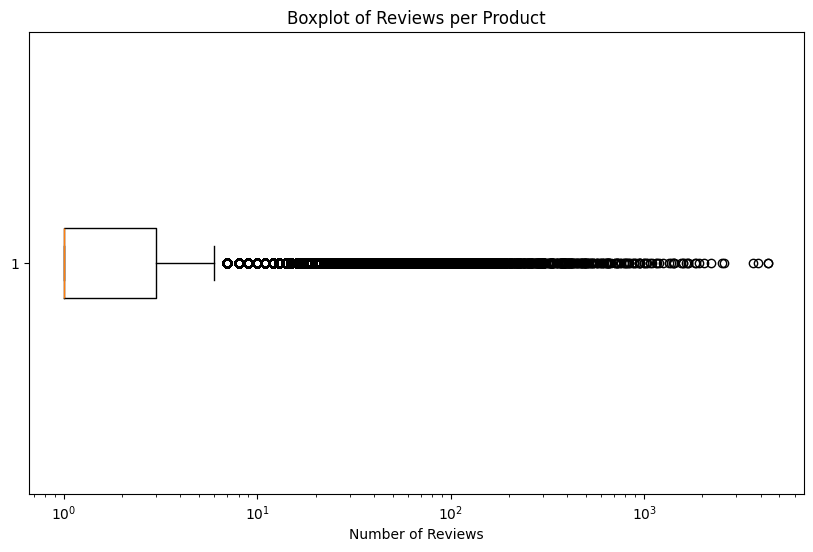

In [13]:
# LEts also check the boxplot - also on a log scale
plt.figure(figsize=(10, 6))
plt.boxplot(reviews_per_product, vert=False)
plt.xlabel('Number of Reviews')
plt.title('Boxplot of Reviews per Product')
plt.xscale('log')  # using a log scale due to the skewness of the data
plt.show()


##### d. Distribution of reviews per user

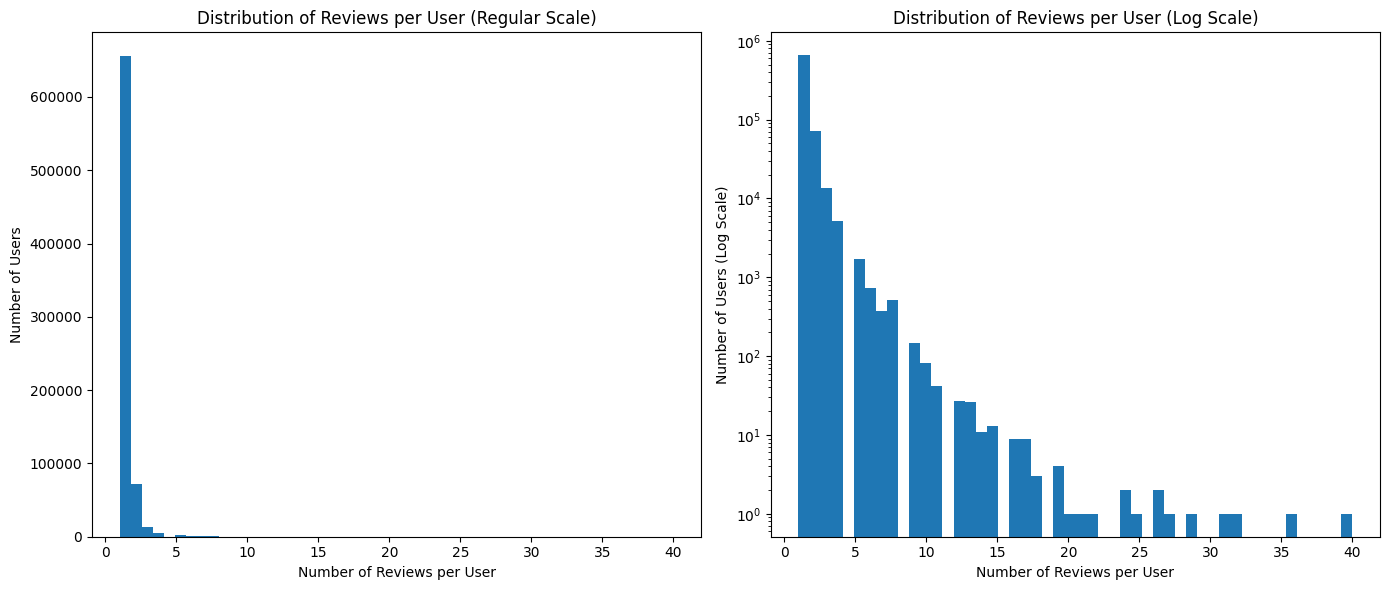

In [19]:
# this can help us determine if a small group of highly active users dominates the dataset

# calculate reviews per user
reviews_per_user = df.groupby('reviewerID')['asin'].count()

# calculate reviews per user
reviews_per_user = df.groupby('reviewerID')['asin'].count()

# set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# regular scale histogram
axes[0].hist(reviews_per_user, bins=50)
axes[0].set_title('Distribution of Reviews per User (Regular Scale)')
axes[0].set_xlabel('Number of Reviews per User')
axes[0].set_ylabel('Number of Users')

# log scale
reviews_per_user_log = reviews_per_user.copy()
reviews_per_user_log[reviews_per_user_log == 0] = 0.1  # add a small value to avoid log(0) when there are users with 0 reviews in the adjusted data
axes[1].hist(reviews_per_user_log, bins=50, log=True)
axes[1].set_title('Distribution of Reviews per User (Log Scale)')
axes[1].set_xlabel('Number of Reviews per User')
axes[1].set_ylabel('Number of Users (Log Scale)')

plt.tight_layout()
plt.show()

##### e. Review lengths and outliers
##### f. Analyze lengths

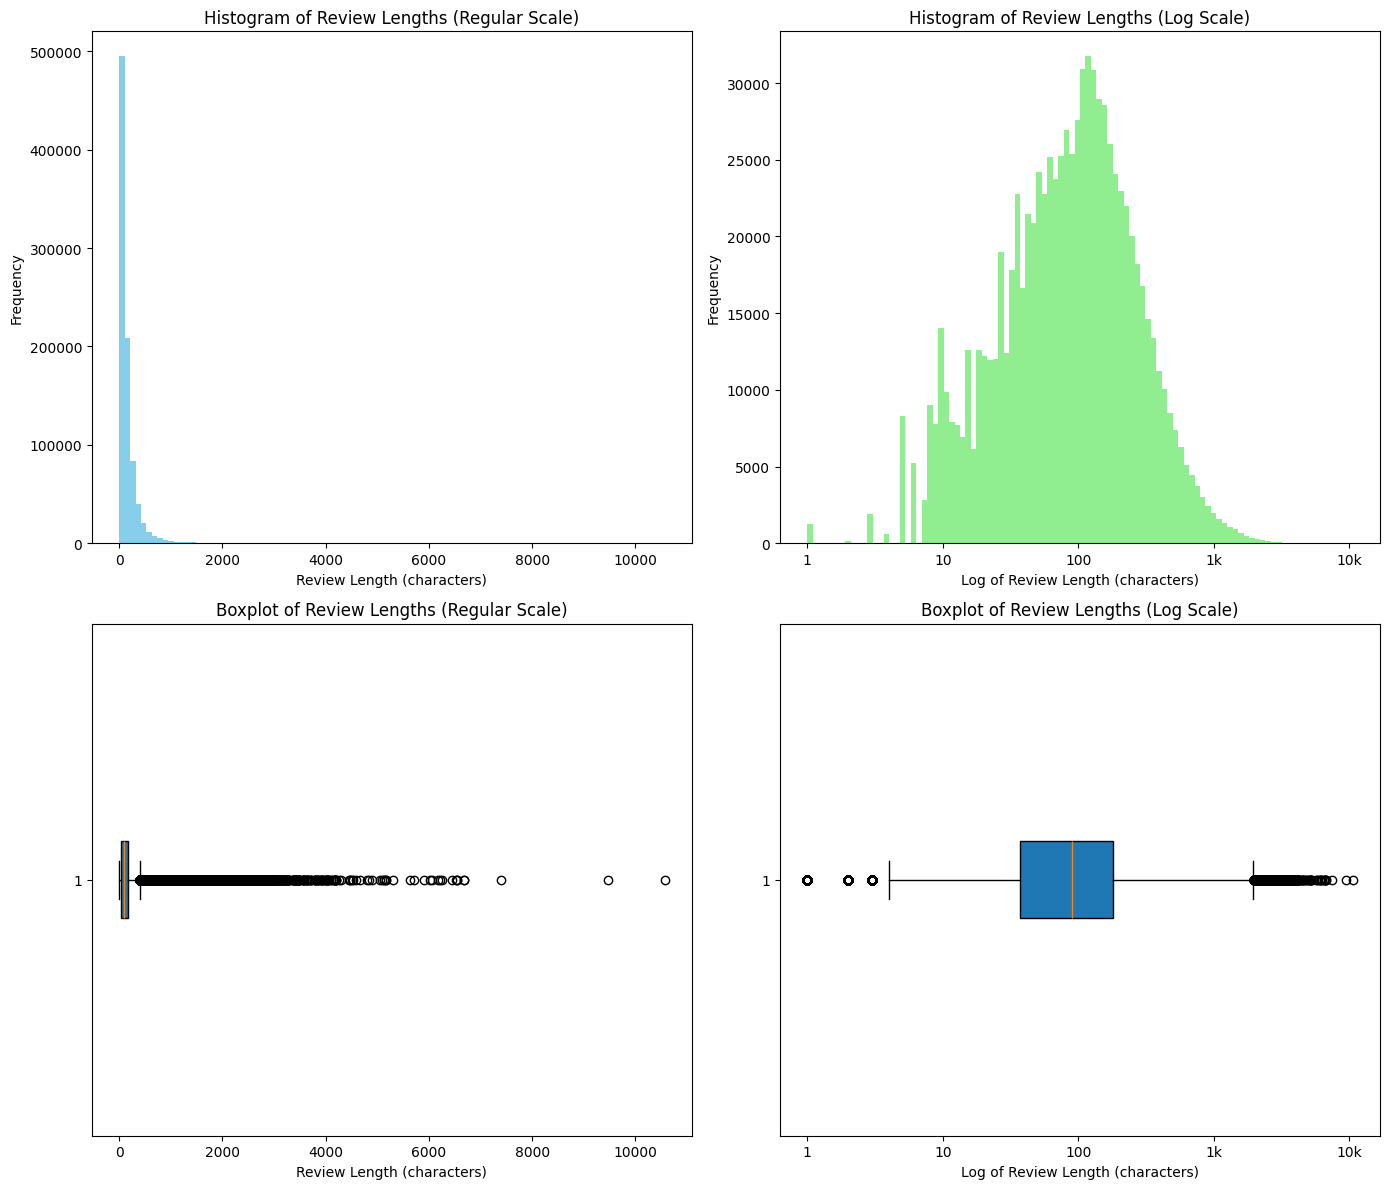

In [26]:
# ensure there are no NaN values or zeros in review lengths for log scale so we dont have log(0)
df['review_length'] = df['reviewText'].str.len().fillna(0)
# shift the scale of the review lengths by 1 to perform log tranformation
df['review_length_log'] = df['review_length'].apply(lambda x: np.log10(x + 1))  # log(0 + 1) = 0

# set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Regular scale histogram
axes[0, 0].hist(df['review_length'], bins=100, color='skyblue')
axes[0, 0].set_title('Histogram of Review Lengths (Regular Scale)')
axes[0, 0].set_xlabel('Review Length (characters)')
axes[0, 0].set_ylabel('Frequency')

# Log scale histogram
axes[0, 1].hist(df['review_length_log'], bins=100, color='lightgreen')
axes[0, 1].set_title('Histogram of Review Lengths (Log Scale)')
axes[0, 1].set_xlabel('Log of Review Length (characters)')
axes[0, 1].set_ylabel('Frequency')
# Adjusting x-axis to reflect powers of 10
axes[0, 1].set_xticks([0, 1, 2, 3, 4])  # Corresponds to 1, 10, 100, 1000, 10000 characters
axes[0, 1].set_xticklabels(['1', '10', '100', '1k', '10k'])

# Regular scale boxplot
axes[1, 0].boxplot(df['review_length'], vert=False, patch_artist=True)
axes[1, 0].set_title('Boxplot of Review Lengths (Regular Scale)')
axes[1, 0].set_xlabel('Review Length (characters)')

# Log scale boxplot
axes[1, 1].boxplot(df['review_length_log'], vert=False, patch_artist=True)
axes[1, 1].set_title('Boxplot of Review Lengths (Log Scale)')
axes[1, 1].set_xlabel('Log of Review Length (characters)')
# Adjusting x-axis for the boxplot as well
axes[1, 1].set_xticks([0, 1, 2, 3, 4])
axes[1, 1].set_xticklabels(['1', '10', '100', '1k', '10k'])

plt.tight_layout()
plt.show()

##### g. Check for duplicates
We will check for exact dupes and near dupes\
\
Exact dupes will be rows where every piece of metedata is identical\
Near dupes might occur when the same review is posted multiple times with slight variations, such as timestamps or minor edits. This can be challenging to find, but we will try.

In [ ]:
# # check for exact duplicates
# exact_duplicates = df.duplicated(keep=False)  # 'keep=False' marks all duplicates as True

# # count exact duplicates
# exact_duplicates_count = exact_duplicates.sum()

# # display duplicate rows
# print(df[exact_duplicates])

# # removing exact duplicates
# df_no_exact_duplicates = df.drop_duplicates()

# # print the number of duplicates removed
# print(f"Exact duplicates found and removed: {exact_duplicates_count}")

The above cell failed because there were dictionaries detected as values in some of the columns

In [34]:
# initialize an empty list to hold the names of columns containing dictionaries
columns_with_dicts = []

# check each column for dictionary data types
for column in df.columns:
    # check if any element in the column is a dictionary
    if any(isinstance(x, dict) for x in df[column].dropna()):
        columns_with_dicts.append(column)

# print out the columns that contain dictionaries
print("Columns containing dictionaries:", columns_with_dicts)

Columns containing dictionaries: []


Images were also found to contain lists

In [32]:
# convert dictionary columns to string for duplication check
df['style'] = df['style'].apply(lambda x: str(x) if isinstance(x, dict) else x) # converts dictionaries to str
df['image'] = df['image'].apply(lambda x: str(x) if isinstance(x, list) else x) # converts lists to str

# check for dupes across all columns
exact_duplicates = df.duplicated(keep=False)
exact_duplicates_count = exact_duplicates.sum()
df_no_exact_duplicates = df.drop_duplicates()
print(f"Exact duplicates found and removed: {exact_duplicates_count}")

Exact duplicates found and removed: 14518


for near dupes a simple approach is to compare the data after normalizing (i.e. lowercasing, removing punctuation, etc.)\
A more robust approach would be to vectorize and use similarity measures (cosine), but we will leave that as a maybe for now.

In [33]:
# normalize text simple version
df['reviewText_normalized'] = df['reviewText'].str.lower().str.replace(r'\W', '', regex=True)

# check for duplicates based on 'reviewerID', 'asin', and the normalized review text
near_duplicates = df.duplicated(subset=['reviewerID', 'asin', 'reviewText_normalized'], keep=False)

# count near duplicates
near_duplicates_count = near_duplicates.sum()

# print the number of near duplicates found - will need to decide what to do with these
print(f"Near duplicates found: {near_duplicates_count}")

Near duplicates found: 15001


This will need more exploration and analysis before we axe all of these values from the dataset, but at least our near dupe detector found quite a few records.